In [1]:
%matplotlib inline
import torch
import pandas as pd
import numpy as np
import sys
import torch.nn as nn
sys.path.append("..")
import d2lzh_pytorch as d2l

print(torch.__version__)
torch.set_default_tensor_type(torch.FloatTensor)

1.4.0


In [2]:
train_data = pd.read_csv(r'/Users/zhangxiao/Desktop/Jupyter/Pytorch/house-prices-advanced-regression-techniques/train.csv')
test_data = pd.read_csv(r'/Users/zhangxiao/Desktop/Jupyter/Pytorch/house-prices-advanced-regression-techniques/test.csv')                      

In [3]:
train_data.shape

(1460, 81)

In [4]:
test_data.shape

(1459, 80)

In [5]:
train_data.iloc[0:5, [0, 1, 2, 3, -3, -2, -1]]

,Id,MSSubClass,MSZoning,LotFrontage,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,WD,Normal,208500
1,2,20,RL,80.0,WD,Normal,181500
2,3,60,RL,68.0,WD,Normal,223500
3,4,70,RL,60.0,WD,Abnorml,140000
4,5,60,RL,84.0,WD,Normal,250000


In [6]:
test_data.iloc[0:5, [0, 1, 2, 3, -3, -2, -1]]

,Id,MSSubClass,MSZoning,LotFrontage,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,2010,WD,Normal
1,1462,20,RL,81.0,2010,WD,Normal
2,1463,60,RL,74.0,2010,WD,Normal
3,1464,60,RL,78.0,2010,WD,Normal
4,1465,120,RL,43.0,2010,WD,Normal


In [7]:
all_features = pd.concat((train_data.iloc[:, 1:-1], test_data.iloc[:, 1:])) # 按行连接

In [8]:
all_features.shape

(2919, 79)

In [9]:
numeric_features = all_features.dtypes[all_features.dtypes != 'object'].index #把属性的索引提取出来
all_features[numeric_features] = all_features[numeric_features].apply(lambda x: (x - x.mean()) / (x.std())) #因为上
                                                            #一步已经将属性索引行除去了，所以这里只有数据参与计算，下面是解释   
all_features = all_features.fillna(0)

In [10]:
#a = pd.DataFrame({'a': [1, 2, 3, 4, np.nan], 'b': [1, 3, np.nan, 5, 6]})

In [11]:
#a

In [12]:
#b = a.dtypes[a.dtypes != 'object'].index

In [13]:
#b

In [14]:
#a.dtypes

In [15]:
#a['a']

In [16]:
#a['b']

In [17]:
#a.dtypes != 'object'

In [18]:
all_features.shape

(2919, 79)

In [19]:
all_features = pd.get_dummies(all_features, dummy_na=True)

In [20]:
all_features.shape

(2919, 354)

In [21]:
all_features.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,SaleType_Oth,SaleType_WD,SaleType_nan,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,SaleCondition_nan
0,0.067320,-0.184443,-0.217841,0.646073,-0.507197,1.046078,0.896679,0.523038,0.580708,-0.29303,...,0,1,0,0,0,0,0,1,0,0
1,-0.873466,0.458096,-0.072032,-0.063174,2.187904,0.154737,-0.395536,-0.569893,1.177709,-0.29303,...,0,1,0,0,0,0,0,1,0,0
2,0.067320,-0.055935,0.137173,0.646073,-0.507197,0.980053,0.848819,0.333448,0.097840,-0.29303,...,0,1,0,0,0,0,0,1,0,0
3,0.302516,-0.398622,-0.078371,0.646073,-0.507197,-1.859033,-0.682695,-0.569893,-0.494771,-0.29303,...,0,1,0,1,0,0,0,0,0,0
4,0.067320,0.629439,0.518814,1.355319,-0.507197,0.947040,0.753100,1.381770,0.468770,-0.29303,...,0,1,0,0,0,0,0,1,0,0


In [22]:
n_train = train_data.shape[0]
train_features = torch.tensor(all_features[:n_train].values,
dtype=torch.float)
test_features = torch.tensor(all_features[n_train:].values,
dtype=torch.float)
train_labels = torch.tensor(train_data.SalePrice.values,
dtype=torch.float).view(-1, 1)

In [23]:
loss = torch.nn.MSELoss()
def get_net(feature_num):
    net = nn.Linear(feature_num, 1) 
    for param in net.parameters():
        nn.init.normal_(param, mean=0, std=0.01) 
    return net

In [24]:
def log_rmse(net, features, labels): 
    with torch.no_grad():
        clipped_preds = torch.max(net(features), torch.tensor(1.0)) 
        rmse = torch.sqrt(2 * loss(clipped_preds.log(),
labels.log()).mean()) 
        return rmse.item()

In [25]:
def train(net, train_features, train_labels, test_features, test_labels,
num_epochs, learning_rate, weight_decay, batch_size): 
    train_ls, test_ls = [], []
    dataset = torch.utils.data.TensorDataset(train_features,
train_labels)
    train_iter = torch.utils.data.DataLoader(dataset, batch_size,
shuffle=True)
# Adam
    optimizer = torch.optim.Adam(params=net.parameters(),
    lr = learning_rate, weight_decay=weight_decay) 
    net = net.float()
    for epoch in range(num_epochs):
        for X, y in train_iter:
            l = loss(net(X.float()), y.float()) 
            optimizer.zero_grad()
            l.backward()
            optimizer.step()
        train_ls.append(log_rmse(net, train_features, train_labels))
        if test_labels is not None: 
            test_ls.append(log_rmse(net, test_features,
test_labels))

    return train_ls, test_ls

In [26]:
def get_k_fold_data(k, i, X, y):
    assert k > 1
    fold_size = X.shape[0] // k
    X_train, y_train = None, None
    for j in range(k):
        idx = slice(j * fold_size, (j + 1) * fold_size)
        X_part, y_part = X[idx, :], y[idx]
        if j == i:
            X_valid, y_valid = X_part, y_part
        elif X_train is None:
            X_train, y_train = X_part, y_part
        else:
            X_train = torch.cat((X_train, X_part), dim=0)
            y_train = torch.cat((y_train, y_part), dim=0)
    return X_train, y_train, X_valid, y_valid

In [27]:
def k_fold(k, X_train, y_train, num_epochs, learning_rate, weight_decay, batch_size):
    train_l_sum, valid_l_sum = 0, 0 
    for i in range(k):
        data = get_k_fold_data(k, i, X_train, y_train)
        net = get_net(X_train.shape[1])
        train_ls, valid_ls = train(net, *data, num_epochs,
learning_rate,  weight_decay, batch_size)
        train_l_sum += train_ls[-1] 
        valid_l_sum += valid_ls[-1] 
        if i == 0:       
            d2l.semilogy(range(1, num_epochs + 1), train_ls, 'epochs', 'rmse',
range(1, num_epochs + 1), valid_ls, ['train', 'valid'])
        print('fold %d, train rmse %f, valid rmse %f' % (i, train_ls[-1], valid_ls[-1]))
    return train_l_sum / k, valid_l_sum / k

fold 0, train rmse 0.240314, valid rmse 0.221077
fold 1, train rmse 0.229037, valid rmse 0.266099
fold 2, train rmse 0.231999, valid rmse 0.238781
fold 3, train rmse 0.237904, valid rmse 0.219031
fold 4, train rmse 0.230307, valid rmse 0.258583
5-fold validation: avg train rmse 0.233912, avg valid rmse 0.240714


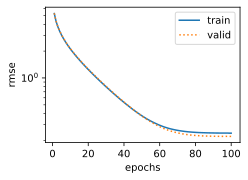

In [28]:
k, num_epochs, lr, weight_decay, batch_size = 5, 100, 5, 0, 64  
train_l, valid_l = k_fold(k, train_features, train_labels,
num_epochs, lr, weight_decay, batch_size)
print('%d-fold validation: avg train rmse %f, avg valid rmse %f' %
(k, train_l, valid_l))

In [31]:
def train_and_pred(train_features, test_features, train_labels, test_data,
num_epochs, lr, weight_decay, batch_size): 
    net = get_net(train_features.shape[1])
    train_ls, _ = train(net, train_features, train_labels, None, None,
num_epochs, lr, weight_decay, batch_size) 
    d2l.semilogy(range(1, num_epochs + 1), train_ls, 'epochs', 'rmse')
    print('train rmse %f' % train_ls[-1])
    preds = net(test_features).detach().numpy() 
    test_data['SalePrice'] = pd.Series(preds.reshape(1, -1)[0]) 
    submission = pd.concat([test_data['Id'],test_data['SalePrice']], axis=1) 
    submission.to_csv('./submission.csv', index=False)

train rmse 0.229615


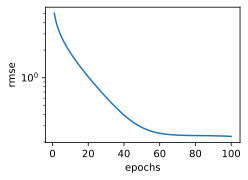

In [32]:
train_and_pred(train_features, test_features, train_labels, test_data, num_epochs, lr, weight_decay, batch_size)